In [1]:
from torchvision.models import *
import wandb
from sklearn.model_selection import train_test_split
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import *
import torch,torchvision
from tqdm import tqdm
device = 'cuda'
PROJECT_NAME = 'Shapes-Clf'

In [2]:
def load_data():
    labels = {}
    data = []
    labels_r = {}
    idx = 0
    for folder in os.listdir('./data/'):
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
    for folder in tqdm(os.listdir('./data/')):
#         print(folder)
        for file in os.listdir(f'./data/{folder}/')[:1000]:
            img = cv2.imread(f'./data/{folder}/{file}')
            img = cv2.resize(img,(56,56))
            img = img / 255.0
            data.append([img,np.eye(labels[folder],len(labels))[labels[folder]-1]])
    X = []
    y = []
    for d in data:
        X.append(d[0])
        y.append(d[1])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    X_train = torch.from_numpy(np.array(X_train)).to(device).view(-1,3,56,56).float()
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).view(-1,3,56,56).float()
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X,y,X_train,X_test,y_train,y_test,labels,labels_r,idx,data

In [3]:
X,y,X_train,X_test,y_train,y_test,labels,labels_r,idx,data = load_data()

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


In [4]:
# torch.save(X_train,'X_train.pt')
# torch.save(y_train,'y_train.pt')
# torch.save(X_test,'X_test.pt')
# torch.save(y_test,'y_test.pt')
# torch.save(labels_r,'labels_r.pt')
# torch.save(labels,'labels.pt')
torch.save(X_train,'X_train.pth')
torch.save(y_train,'y_train.pth')
torch.save(X_test,'X_test.pth')
torch.save(y_test,'y_test.pth')
torch.save(labels_r,'labels_r.pth')
torch.save(labels,'labels.pth')

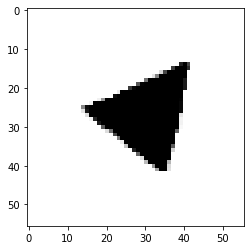

In [5]:
plt.imshow(X_train[0].view(56,56,3).cpu())

In [6]:
labels_r[int(torch.argmax(y_train[0]))+1]

'triangle'

In [7]:
def get_loss(model,X,y,criterion):
    preds = model(X)
    loss = criterion(preds,y)
    return loss.item()

In [8]:
def get_accuracy(model,X,y):
    preds = model(X)
    correct = 0
    total = 0
    for pred,y_batch in zip(preds,y):
        pred = int(torch.argmax(pred))
        y_batch = int(torch.argmax(y_batch))
        if pred == y_batch:
            correct += 1
        total += 1
    acc = round(correct/total,3)*100
    return acc

In [9]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(3,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(21*3*3,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,256)
        self.linear3bn = BatchNorm1d(256)
        self.output = Linear(256,len(labels))
    
    def forward(self,X):
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
#         print(preds.shape)
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.output(preds)
        return preds

In [10]:
model = Model().to(device)
criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 100
batch_size = 32

In [11]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    wandb.watch(model)
    for i in range(0,len(X_train),batch_size):
        torch.cuda.empty_cache()
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    wandb.log({'Loss':(get_loss(model,X_train,y_train,criterion)+get_loss(model,X_batch,y_batch,criterion))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    torch.cuda.empty_cache()
    wandb.log({'Acc':(get_accuracy(model,X_train,y_train)+get_accuracy(model,X_batch,y_batch))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val ACC':get_accuracy(model,X_test,y_test)})
    torch.cuda.empty_cache()
    wandb.watch(model)
wandb.watch(model)
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/indika/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


wandb: Network error (ConnectionError), entering retry loop.


Loss,0.0214
_runtime,108
_timestamp,1631717999
_step,399
Val Loss,0.40656
Acc,98.1
Val ACC,0.0


Loss,▇█▇▆▃▂▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▂▁▁▂▂▁▁▁▂▂▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Val Loss,▆█▆▅▃▂▂▃▃▃▄▄▄▅▄▄▄▃▃▂▃▂▃▂▂▂▁▁▃▂▂▂▂▄▂▂▂▂▃▃
Acc,▁▁▁▁▇▇███████████████████▆███████▇▇█████
Val ACC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
